<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/MLP_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-layered Perceptron (MLP)

Network structure and hyper-parameter search by Optuna

Classification of handwritten numbers (MNIST) by MLP

In [69]:
!pip install optuna

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
# plot graph
import matplotlib.pyplot as plt


In [71]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数
 
print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))


train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


In [72]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=64,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)


In [73]:
import optuna

img_height = 28
img_width = 28
kernel_width = 3
num_classes = 10

# Multi Layer Perceptron Network
class MLPNet (nn.Module):
    def __init__(self, mid_units):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(img_height * img_width * 1, mid_units)
        self.fc2 = nn.Linear(mid_units, num_classes)
#        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        y = torch.relu(self.fc1(x))
#        y = torch.sigmoid(self.fc1(x))
#        y = torch.tanh(self.fc1(x))
#        y = self.dropout1(y)
        z = self.fc2(y)
        return z

In [74]:
def train(net, device, train_loader, optimizer, criterion):
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        images, labels = images.view(-1, img_height * img_width * 1).to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
def test(net, device, test_loader, criterion):
    val_loss, val_acc = 0, 0
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
          images, labels = images.view(-1,img_height * img_width * 1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    return avg_val_acc
    

In [75]:
import torch.optim as optim

nepoch = 100
def objective(trial):
    # select device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    mid_units =  trial.suggest_int("mid_units", 1000, 2000, step = 500)
    #nepoch = trial.suggest_int("nepoch", 10, 110, step=20)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1.0e-5, 0.01, log=True)
    
    net = MLPNet(mid_units).to(device)
    
    # optimizing
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    #optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)

    for step in range(nepoch):
#        print('epochs = ', step)
        train(net, device, train_loader, optimizer, criterion)
        error_rate = test(net, device, test_loader, criterion)

    return error_rate

In [76]:
ntrial = 50
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=ntrial)

[I 2024-09-23 09:30:40,479] A new study created in memory with name: no-name-c4e59bd3-e1a0-4aa1-92bb-cdf216dcd180
[I 2024-09-23 09:40:38,251] Trial 0 finished with value: 0.9311666666666667 and parameters: {'mid_units': 500, 'nepoch': 90, 'learning_rate': 0.00015375800949947124, 'weight_decay': 1.5871507464499615e-05}. Best is trial 0 with value: 0.9311666666666667.
[I 2024-09-23 09:52:47,750] Trial 1 finished with value: 0.9845 and parameters: {'mid_units': 500, 'nepoch': 110, 'learning_rate': 0.08133149788543603, 'weight_decay': 1.4324656115372574e-05}. Best is trial 1 with value: 0.9845.
[I 2024-09-23 10:02:37,516] Trial 2 finished with value: 0.983 and parameters: {'mid_units': 700, 'nepoch': 90, 'learning_rate': 0.016298566769952744, 'weight_decay': 0.0001153100755717359}. Best is trial 1 with value: 0.9845.
[I 2024-09-23 10:03:45,484] Trial 3 finished with value: 0.9755 and parameters: {'mid_units': 100, 'nepoch': 10, 'learning_rate': 0.019158222413523048, 'weight_decay': 0.00014

In [77]:
print(study.best_params)
print(study.best_value)

{'mid_units': 1300, 'nepoch': 90, 'learning_rate': 0.09597036344452625, 'weight_decay': 6.914477747820427e-05}
0.9866666666666667


In [78]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###  Final training with the optimum model
print ('training start ...')
mid_units = study.best_params['mid_units']   
num_epochs = study.best_params['nepoch']
learning_rate = study.best_params['learning_rate']
weight_decay = study.best_params['weight_decay']

net = MLPNet(mid_units).to(device)
    
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
        images, labels = images.view(-1, img_height * img_width * 1).to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
          images, labels = images.view(-1, img_height * img_width * 1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...


Epoch [1/90] train Loss: 0.0015, train acc: 0.9701 | val_loss: 0.0019, val_acc: 0.9633
Epoch [2/90] train Loss: 0.0009, train acc: 0.9813 | val_loss: 0.0014, val_acc: 0.9716
Epoch [3/90] train Loss: 0.0007, train acc: 0.9854 | val_loss: 0.0013, val_acc: 0.9740
Epoch [4/90] train Loss: 0.0005, train acc: 0.9911 | val_loss: 0.0011, val_acc: 0.9771
Epoch [5/90] train Loss: 0.0006, train acc: 0.9882 | val_loss: 0.0014, val_acc: 0.9731
Epoch [6/90] train Loss: 0.0003, train acc: 0.9952 | val_loss: 0.0011, val_acc: 0.9804
Epoch [7/90] train Loss: 0.0002, train acc: 0.9983 | val_loss: 0.0009, val_acc: 0.9826
Epoch [8/90] train Loss: 0.0001, train acc: 0.9985 | val_loss: 0.0009, val_acc: 0.9826
Epoch [9/90] train Loss: 0.0001, train acc: 0.9991 | val_loss: 0.0009, val_acc: 0.9833
Epoch [10/90] train Loss: 0.0001, train acc: 0.9995 | val_loss: 0.0009, val_acc: 0.9830
Epoch [11/90] train Loss: 0.0001, train acc: 0.9998 | val_loss: 0.0009, val_acc: 0.9831
Epoch [12/90] train Loss: 0.0001, train a

In [79]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, img_height * img_width * 1).to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 


test_accuracy: 98.35 %


In [80]:
# save weights (You can save the model by uncomment the following line)
import os
if not os.path.exists('trained_models'):
    os.mkdir('trained_models')
torch.save(net.state_dict(), './trained_models/MLP_mnist_optuna_best.pth')

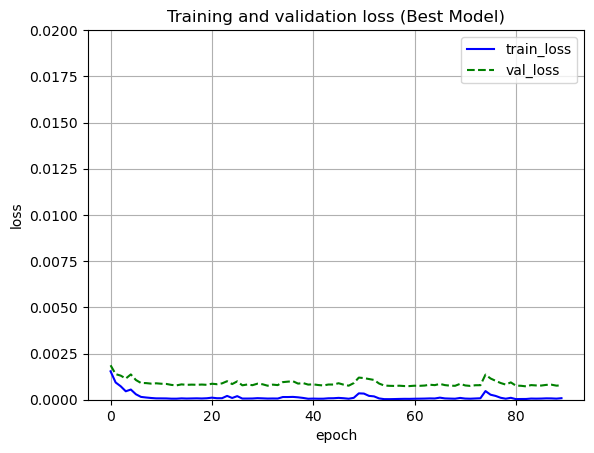

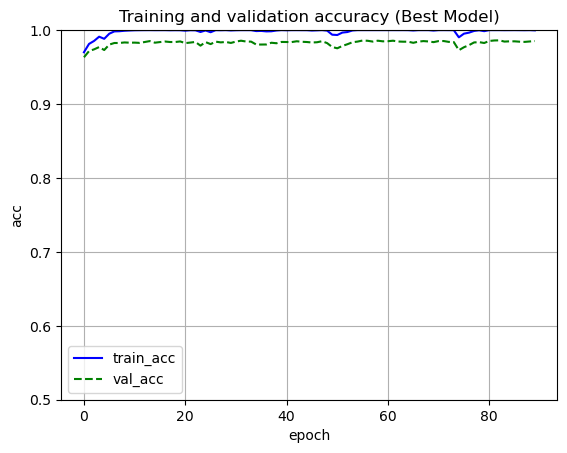

In [81]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss (Best Model)')
plt.grid()
plt.savefig('MLP_mnist_optuna_best_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy (Best Model)')
plt.grid()
plt.savefig('MLP_mnist_optuna_best_acc.png')
plt.show()